In [1]:
# Import of the necessary libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")


from pca import pca

## Accuracy
from sklearn.metrics import mean_squared_error

from factor_analyzer import FactorAnalyzer

## Building Model
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
# import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Data Visualization
import seaborn as sn
import matplotlib.pyplot as plt

## Multidimensional Scaling
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## 1) clinical_trajectories_df.xlsx : Predict clinical trajectories of neurological conditions

#### Dataset exploration :
The given dataset contains diagnostic data from patients with neurological disorders. For each patient, **records are given of 80 different symptoms. These symptopms are categoriesed into 13 main groups under 5 domains (General, Cognitive, Motor, Psychiatric and Sensory).** 


#### Expectations:
The goal of analsys is to search influential underlying factors(symptoms) to predict the clinical trajectories of neurological conditions of a patient.


####  Factor Analysis (FA)
Factor analysis is an machine learning algorithms which is used for dimensionality reduction. This algorithm creates factors from the observed variables to represent the common variance i.e. variance due to correlation among the observed variables.


#### Rationale for using FA
Since the goal of the analysis is to reduce the number of factors(symptom) and to find out the most significant groups of the symptoms, I think **Factor Analysis (FA)** will be the best method for component analysis of this dataset. 

### Data Preparation

In [2]:
# The dataset (excel file) contains several excel sheets where first sheet contains the data 
# and rest of the sheets contanins Metadata, Attribute and Diagnosis information.

# Lets read the data from the excel file

clinical_trajectories_df = pd.read_excel('clinical_trajectories_df.xlsx', sheet_name=0)
# df.head(10)

In [96]:
df = clinical_trajectories_df

In [97]:
# The dataset contains information which are not relavent in our analysis such as DonorID, Gender, Age, Year etc.
# Lets drop these columns

drop_list = [
    "DonorID", "neuropathological_diagnosis", "Gender", "Year_donor_death", 
    "Year", "Age", "year_before_death", "chars_in_clin",
]


df = df.drop(drop_list, axis=1)

In [98]:
df.head()

,age_at_death,Muscular_Weakness,Spasticity,Hyperreflexia_and_oth_reflexes,Fasciculations,Positive_sensory_symptoms,Negative_sensory_symptoms,Parkinsonism,Facial_masking,Tremor,...,Orthostatic_hypotension,Headache_migraine,Fatigue,Declined_deteriorated_health,Cachexia,Weight_loss,Reduces_oral_intake,Help_in_ADL,Day_care,Admission_to_nursing_home
0,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
#Now check the missing values in the dataset
print("Total missing values: ", df.isnull().sum().sum())

Total missing values:  0


It seems dataset is clean and there is no missing or NULL values in the dataset. 

### Codes to perform Factor Analysis:

Before peforming the Factor Analysis, I need to evaluate the "factorability" of the dataset. Factorability means "can we find the factors in the dataset?". There are two methods to check the factorability:

<li>Bartlett's test </li>
<li>Kaiser-Meyer-Olkin (KMO)</li>

https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html

**Bartlett's test** checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, we should not employ the factor analysis.

In [101]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df)
chi_square_value, p_value

(268663.2777652952, 0.0)

In this Bartlett's test, **the p-value is 0**. The test is statistically significant, indicating that the observed correlation matrix is not an identity matrix.

Another test methods is **Kaiser-Meyer-Olkin (KMO)**  which measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate. (https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html)

In [102]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df)
kmo_model

0.9020195962811561

The overall KMO for our data is **0.90**, which is excellent. This value indicates that I can proceed with my planned factor analysis.

### Choosing the Number of Factors

In [103]:
# Initiallly lets create factor analysis object with n_factors = 10

fa = FactorAnalyzer(n_factors = 10, rotation='varimax')
fa.fit(df)

FactorAnalyzer(n_factors=10, rotation='varimax', rotation_kwargs={})

In [105]:
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([6.68080564, 3.44094759, 2.18678125, 2.12743793, 1.77839546,
       1.53755147, 1.40131103, 1.29894263, 1.22668879, 1.18539364,
       1.17198001, 1.12382114, 1.10407477, 1.08295749, 1.05610554,
       1.04745245, 1.04271663, 1.01927052, 1.00994585, 1.00240139,
       0.98599046, 0.98211924, 0.97901112, 0.96590396, 0.96158556,
       0.95733986, 0.94817279, 0.9362059 , 0.92769698, 0.92042648,
       0.91284349, 0.90893602, 0.90282111, 0.89230055, 0.89020141,
       0.87689612, 0.86345401, 0.85543456, 0.8506521 , 0.84730697,
       0.842134  , 0.83455781, 0.82990177, 0.823223  , 0.81504349,
       0.81035632, 0.80847451, 0.80236223, 0.79393685, 0.78912378,
       0.78044554, 0.7778423 , 0.77041082, 0.76090744, 0.75685617,
       0.75208043, 0.74125436, 0.73151656, 0.72569516, 0.72546593,
       0.71925763, 0.71527535, 0.71154769, 0.70884938, 0.69974746,
       0.6934304 , 0.67890963, 0.67133875, 0.65984879, 0.65602211,
       0.65384824, 0.64881304, 0.63913778, 0.63198825, 0.62033

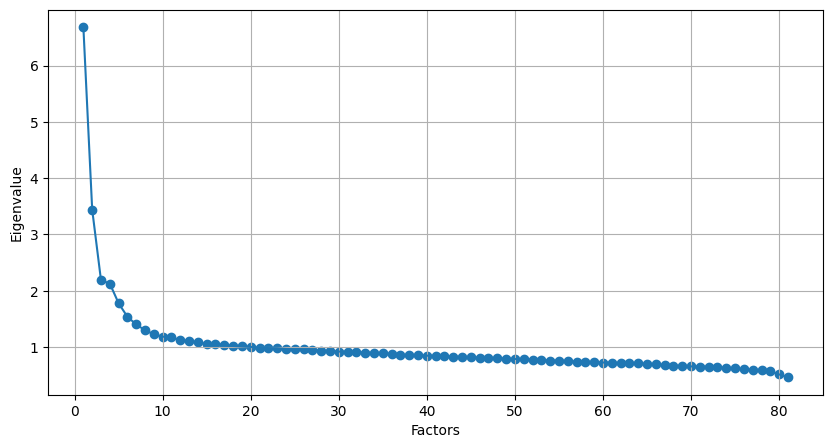

In [106]:
# Create scree plot
plt.figure(figsize=(10, 5))

plt.scatter(range(1, df.shape[1]+1), ev)
plt.plot(range(1, df.shape[1]+1), ev)

# plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')

plt.grid()
plt.show()

From the above screen plot and eigenvalues, we can see that **20 eigenvalues are greater than 1**. That means I need to choose 20 factors.

### Performing Factor Analysis

In [107]:
# Create factor analysis object with n_factors = 3
fa = FactorAnalyzer(n_factors = 20, rotation='varimax')
fa.fit(df)

FactorAnalyzer(n_factors=20, rotation='varimax', rotation_kwargs={})

In [115]:
# pd.DataFrame.from_records(fa.loadings_)

fa_loadings_df = pd.DataFrame(fa.loadings_,index=df.columns)
fa_loadings_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
age_at_death,-0.007147,0.004243,-0.194238,0.027823,0.017368,-0.089457,0.017162,-0.019861,-0.065600,0.054028,-0.011119,-0.012540,0.065835,0.049832,-0.088465,-0.013862,-0.109454,-0.007475,-0.377286,-0.076122
Muscular_Weakness,0.009643,0.094949,0.509778,-0.024566,0.041891,0.009908,-0.007635,0.085355,-0.003988,0.074075,0.076255,0.043950,0.034557,-0.000857,0.014877,0.213127,0.081321,-0.024063,0.044774,-0.092783
Spasticity,-0.028039,0.000654,0.305922,-0.012150,0.050166,-0.009777,-0.012401,0.094416,0.003902,-0.018541,0.126070,-0.003007,-0.028138,0.003180,-0.019612,0.082096,-0.021865,0.016299,0.139783,-0.022291
Hyperreflexia_and_oth_reflexes,0.042722,0.111731,0.614140,0.005135,0.004182,0.001023,-0.009406,-0.027588,0.015617,-0.008365,0.037554,0.035756,0.038199,-0.000461,0.012058,0.101270,-0.025892,-0.021592,-0.016891,-0.015620
Fasciculations,0.013728,0.023052,0.099837,0.003170,0.012944,-0.013970,0.000380,-0.002938,0.008159,-0.014817,-0.027208,-0.004376,0.018469,-0.012752,0.014022,0.220310,-0.030748,-0.013880,0.007202,-0.013768
Positive_sensory_symptoms,-0.028460,0.033533,0.289968,-0.029565,-0.025785,-0.000615,-0.008358,-0.022675,-0.015981,-0.030117,0.042722,-0.014150,0.043170,0.023000,-0.001454,0.017849,0.182388,0.002082,0.022130,-0.119063
Negative_sensory_symptoms,0.013962,0.019230,0.534380,-0.007355,-0.017025,0.008131,-0.014717,-0.027039,-0.010814,-0.003828,0.045298,-0.004522,0.019643,0.024894,0.023967,0.052572,0.048500,-0.004835,-0.023691,-0.089275
Parkinsonism,0.046060,0.546127,-0.013432,0.016198,0.020720,0.018543,0.052866,0.056082,0.025780,0.066053,0.031448,-0.000436,0.121812,-0.011228,0.022230,-0.003313,-0.029900,-0.011148,0.017293,-0.064404
Facial_masking,0.079405,0.578208,0.034412,0.022727,-0.002300,-0.004011,-0.001235,-0.016476,0.032887,0.014842,0.016485,-0.000356,-0.017914,0.000530,-0.005309,0.049541,-0.017905,0.018690,-0.010101,0.057261
Tremor,0.019259,0.472441,0.117203,0.015867,0.011011,0.015250,0.016248,0.005335,0.050854,0.006310,0.010985,-0.020816,0.001442,0.008624,-0.021097,-0.015699,0.020732,0.006835,-0.014639,-0.010646


**Factor Loadings** indicate how much a factor explains a variable. The loading score will range from -1 to 1. **Values close to -1 or 1 indicate that the factor has an influence on these variables.** Values close to 0 indicates that the factor has a lower influencer on the variable.

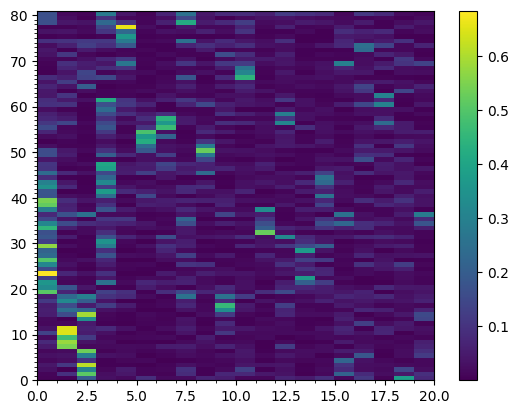

In [116]:
import numpy as np
Z=np.abs(fa.loadings_)
fig, ax = plt.subplots()
c = ax.pcolor(Z)

fig.colorbar(c, ax=ax)
ax.set_yticks(np.arange(fa.loadings_.shape[0]), minor=True)
ax.set_xticks(np.arange(fa.loadings_.shape[1]), minor=True)

plt.show()

For better understanding, lets transpose the dataframe.

In [109]:
fa_loadings_df = fa_loadings_df.transpose()

In [110]:
fa_loadings_df.head(20)# there are 20 factors

,age_at_death,Muscular_Weakness,Spasticity,Hyperreflexia_and_oth_reflexes,Fasciculations,Positive_sensory_symptoms,Negative_sensory_symptoms,Parkinsonism,Facial_masking,Tremor,...,Orthostatic_hypotension,Headache_migraine,Fatigue,Declined_deteriorated_health,Cachexia,Weight_loss,Reduces_oral_intake,Help_in_ADL,Day_care,Admission_to_nursing_home
0,-0.007147,0.009643,-0.028039,0.042722,0.013728,-0.028460,0.013962,0.046060,0.079405,0.019259,...,0.032273,0.042708,0.021979,0.094134,-0.003969,0.032610,0.006356,0.166687,0.167603,0.167903
1,0.004243,0.094949,0.000654,0.111731,0.023052,0.033533,0.019230,0.546127,0.578208,0.472441,...,0.109055,0.003760,0.059898,0.099095,-0.009027,0.037422,0.007326,0.040757,0.023138,0.013564
2,-0.194238,0.509778,0.305922,0.614140,0.099837,0.289968,0.534380,-0.013432,0.034412,0.117203,...,0.011357,0.049182,0.124869,0.113736,-0.001971,-0.017945,-0.014249,0.033389,-0.000806,0.006637
3,0.027823,-0.024566,-0.012150,0.005135,0.003170,-0.029565,-0.007355,0.016198,0.022727,0.015867,...,0.001921,0.022010,0.092288,0.112229,0.005809,0.105882,0.143420,0.232212,0.098579,0.280194
4,0.017368,0.041891,0.050166,0.004182,0.012944,-0.025785,-0.017025,0.020720,-0.002300,0.011011,...,0.012878,-0.008718,0.185962,0.278766,0.365625,0.230220,0.658448,0.101428,-0.012626,0.037433
5,-0.089457,0.009908,-0.009777,0.001023,-0.013970,-0.000615,0.008131,0.018543,-0.004011,0.015250,...,-0.003696,-0.011842,-0.004696,-0.012376,0.004982,0.008603,0.022526,0.008485,0.008576,-0.007027
6,0.017162,-0.007635,-0.012401,-0.009406,0.000380,-0.008358,-0.014717,0.052866,-0.001235,0.016248,...,0.018009,0.004126,-0.004745,0.016782,0.007968,0.030064,-0.002739,0.059308,0.025261,0.064378
7,-0.019861,0.085355,0.094416,-0.027588,-0.002938,-0.022675,-0.027039,0.056082,-0.016476,0.005335,...,0.005763,-0.009853,0.069356,0.251268,-0.003652,0.024289,0.044073,0.417370,0.148421,0.256437
8,-0.065600,-0.003988,0.003902,0.015617,0.008159,-0.015981,-0.010814,0.025780,0.032887,0.050854,...,-0.006737,0.047980,0.091993,0.036120,0.002227,0.059068,0.014441,0.049324,0.033672,0.041585
9,0.054028,0.074075,-0.018541,-0.008365,-0.014817,-0.030117,-0.003828,0.066053,0.014842,0.006310,...,0.155961,-0.005835,0.062078,0.080201,0.005171,0.023157,0.013436,0.078475,-0.001958,0.078139


In [112]:
# Get the variance, proportional variance, and cumulative variance of each factors

pd.DataFrame(fa.get_factor_variance())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3.465713,2.236678,2.008789,1.835410,0.951275,0.758276,0.742409,0.688722,0.633194,0.599098,0.538940,0.521450,0.485277,0.457304,0.423538,0.406327,0.398001,0.392009,0.328764,0.276394
1,0.042787,0.027613,0.024800,0.022659,0.011744,0.009361,0.009166,0.008503,0.007817,0.007396,0.006654,0.006438,0.005991,0.005646,0.005229,0.005016,0.004914,0.004840,0.004059,0.003412
2,0.042787,0.070400,0.095200,0.117859,0.129603,0.138965,0.148130,0.156633,0.164450,0.171846,0.178500,0.184938,0.190929,0.196575,0.201803,0.206820,0.211733,0.216573,0.220632,0.224044


### Conclusion

Based on the result of factor analysis we observe 20 influential underlying factors to predict the clinical trajectories of neurological conditions of a patient.

For factor 1, the most 5 influential symptopms are Dementia, Concentration_problems, Disorientation, Memory_impairment & Executive_function_disorder.<br>
For factor 2, the most 5 influential symptopms are Tremor, Parkinsonism, Facial_masking, Rigidity, Bradykinesia.<br>
And So on.

Also from the factor varience, we can see total 22% cumulative Variance explained by the 20 factors.

